**Added libraries for woring with Gmail extract and pandas dataframe**

In [ ]:
%pylab inline
import mailbox
import csv
import sys
import pandas as pd


In [91]:
mb = mailbox.mbox('Inbox.mbox')

**Converted .mbox file format into a CSV**


In [92]:
keys = ['Date', 'From', 'X-Gmail-Labels', 'X-GM-THRID']
message_list = []

for message in mb.itervalues():
    dmessage = dict(message.items())
    message_list.append({key:dmessage[key] if key in dmessage.keys() else '' for key in keys})

print (len(message_list), 'messages')
print('**'*50)
message_list[:3]

4834 messages
****************************************************************************************************


[{'Date': 'Sat, 5 Feb 2022 03:21:02 +0000 (UTC)',
  'From': 'Anara Alpyssova via LinkedIn <invitations@linkedin.com>',
  'X-Gmail-Labels': 'Inbox,Category social,Unread',
  'X-GM-THRID': '1723891726467518907'},
 {'Date': 'Thu, 10 Feb 2022 13:17:56 -0800',
  'From': '"Facebook" <friendupdates@facebookmail.com>',
  'X-Gmail-Labels': 'Inbox,Category social,Unread',
  'X-GM-THRID': '1724412467457653322'},
 {'Date': 'Fri, 21 Jan 2022 11:02:26 -0600',
  'From': '"AbeBooks.co.uk" <news@sender.abebooks.co.uk>',
  'X-Gmail-Labels': 'Inbox,Category promotions,Unread',
  'X-GM-THRID': '1722584654539701008'}]

**Created dataframe and analysed how data looks like in the file**

In [107]:
messages = pd.DataFrame(message_list)
#messages.index = messages['Date'].apply(lambda x: pd.to_datetime(x, errors= 'coerce'))
#messages.drop(['Date'], axis=1, inplace=True)
print (messages.shape)
messages.head()

(4834, 4)


,Date,From,X-Gmail-Labels,X-GM-THRID
0,"Sat, 5 Feb 2022 03:21:02 +0000 (UTC)",Anara Alpyssova via LinkedIn <invitations@link...,"Inbox,Category social,Unread",1723891726467518907
1,"Thu, 10 Feb 2022 13:17:56 -0800","""Facebook"" <friendupdates@facebookmail.com>","Inbox,Category social,Unread",1724412467457653322
2,"Fri, 21 Jan 2022 11:02:26 -0600","""AbeBooks.co.uk"" <news@sender.abebooks.co.uk>","Inbox,Category promotions,Unread",1722584654539701008
3,"Fri, 21 Jan 2022 01:52:40 -0600","""MANGO Man"" <news@a.mango.com>","Inbox,Category promotions,Unread",1722549865366624443
4,"Thu, 27 Jan 2022 07:33:32 +0000","""ITVDN"" <info@itvdn.com>","Inbox,Opened,Category updates",1723092238726073413


4263 threads total


Text(0.5, 0, 'Length of Threads')

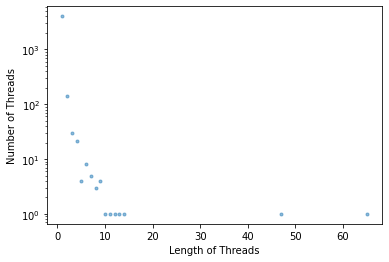

In [5]:
conversation_list = []
threads = messages.groupby(by='X-GM-THRID')
print (len(threads), 'threads total')

counts = threads.aggregate('count')['X-Gmail-Labels'].value_counts()
counts.plot(logy=True, linewidth=0, marker = '.', alpha=.5)
plt.ylabel('Number of Threads')
plt.xlabel('Length of Threads')

In [6]:
from datetime import datetime, timezone
for name, group in threads:
    if len(group) > 1:
        if 'Sent' in group['X-Gmail-Labels'].values:
            group.sort_index(inplace=True)
            tstart = group.index[0]
            tjoin = group[group['X-Gmail-Labels']=='Sent'].index[0]
            tstart1 = tstart.replace(tzinfo=None)
            tjoin1 = tjoin.replace(tzinfo=None)
            conversation_list.append({'tstart':tstart1, 'tjoin':tjoin1})

conversations = pd.DataFrame(conversation_list)
print (conversations.shape)
conversations.head()

(11, 2)


,tstart,tjoin
0,2017-01-08 21:21:53,2017-01-24 13:10:56
1,2019-02-14 15:54:39,2019-02-15 14:32:35
2,2019-06-18 13:16:18,2019-08-21 16:47:15
3,2019-11-03 17:04:29,2019-11-03 14:06:48
4,2019-11-09 09:09:43,2020-01-05 20:16:33


In [7]:

delta = conversations['tjoin']-conversations['tstart']
days = 1.* delta.dt.total_seconds() / 3600 / 24
days.head()

0    15.659062
1     0.943009
2    64.146493
3    -0.123391
4    57.463079
dtype: float64

In [8]:
#days.to_csv('days_to_join_conversation.csv')
#messages.to_csv('Inbox_csv.csv')

**Splitted df columns into meaningful table which will be later visualised**

In [102]:
i = messages.columns.get_loc('Date')
df2 = messages['X-Gmail-Labels'].str.split(",", expand=True, n=2)
df3 = pd.concat([messages.iloc[:, :i], df2, messages.iloc[:, i+1:]], axis=1)

,0,1,2,From,X-Gmail-Labels,X-GM-THRID
0,Inbox,Category social,Unread,Anara Alpyssova via LinkedIn <invitations@link...,"Inbox,Category social,Unread",1723891726467518907
1,Inbox,Category social,Unread,"""Facebook"" <friendupdates@facebookmail.com>","Inbox,Category social,Unread",1724412467457653322
2,Inbox,Category promotions,Unread,"""AbeBooks.co.uk"" <news@sender.abebooks.co.uk>","Inbox,Category promotions,Unread",1722584654539701008
3,Inbox,Category promotions,Unread,"""MANGO Man"" <news@a.mango.com>","Inbox,Category promotions,Unread",1722549865366624443
4,Inbox,Opened,Category updates,"""ITVDN"" <info@itvdn.com>","Inbox,Opened,Category updates",1723092238726073413


In [105]:
#rename new columns
df3.rename(columns={0:"Folder", 1:"Category", 2:"Read status"},inplace=True)
print(df3.columns)
df3.head()

Index(['Folder', 'Category', 'Read status', 'From', 'X-Gmail-Labels',
       'X-GM-THRID'],
      dtype='object')


,Folder,Category,Read status,From,X-Gmail-Labels,X-GM-THRID
0,Inbox,Category social,Unread,Anara Alpyssova via LinkedIn <invitations@link...,"Inbox,Category social,Unread",1723891726467518907
1,Inbox,Category social,Unread,"""Facebook"" <friendupdates@facebookmail.com>","Inbox,Category social,Unread",1724412467457653322
2,Inbox,Category promotions,Unread,"""AbeBooks.co.uk"" <news@sender.abebooks.co.uk>","Inbox,Category promotions,Unread",1722584654539701008
3,Inbox,Category promotions,Unread,"""MANGO Man"" <news@a.mango.com>","Inbox,Category promotions,Unread",1722549865366624443
4,Inbox,Opened,Category updates,"""ITVDN"" <info@itvdn.com>","Inbox,Opened,Category updates",1723092238726073413


In [106]:
#delete email column
df3.drop('From', axis=1, inplace=True)
print(df3.columns)

Index(['Folder', 'Category', 'Read status', 'X-Gmail-Labels', 'X-GM-THRID'], dtype='object')


**Visualisation**